In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%reload_ext autoreload
%autoreload 2

import time
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
import sys
os.chdir('/home/samhuang/ML/')
sys.path.insert(0, '/home/samhuang/ML')
sys.path.insert(0, '/home/samhuang/ML/sample')
from readTFR import *
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.metrics import roc_curve, auc
import models
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import random
from tqdm import tqdm
from train_utils import *
mpl.rcParams['figure.facecolor'] = 'white'

In [6]:
# Data / training parameters.
train_epochs = 500
batch_size = 250
shuffle_size_tr = 0
patience = 10
min_delta = 0.
learning_rate = 1e-4
dim_image = [[75, 75], [[-0.8, 0.8], [-0.8, 0.8]]]
save_model_name = 'best_model_CNN_1-test2/'

# Input datasets
datafile = "/home/samhuang/ML/sample/samples.tfrecord"
#datafile = "/home/samhuang/ML/samples.tfrecord"

#dataset, Ndataset = get_dataset(datafile, repeat=False, batch_size=batch_size, dim_image=dim_image+[True], shuffle=shuffle_size_tr)
#print (Ndataset)
#train_size = int(0.6 * Ndataset/batch_size)
#val_size = int(0.2 * Ndataset/batch_size)
#test_size = int(0.2 * Ndataset/batch_size)
#print ("Data size:")
#print ("Train:", train_size)
#print ("Valid:", val_size)
#print ("Test :", test_size)
#train_dataset = dataset.take(train_size)
#test_dataset = dataset.skip(train_size)
#val_dataset = test_dataset.take(val_size)
#test_dataset = test_dataset.skip(val_size)

# Input datasets
data_tr = "sample/train.tfrecord"
data_vl = "sample/valid.tfrecord" 

dataset_tr, tr_total = get_dataset(data_tr, repeat=False, 
                                   batch_size=batch_size, 
                                   dim_image=dim_image+[True], 
                                   shuffle=shuffle_size_tr)
dataset_vl, vl_total = get_dataset(data_vl, repeat=False, 
                                   batch_size=batch_size, 
                                   dim_image=dim_image+[True], 
                                   shuffle=0)

The data set contains images
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
The data set contains images


2022-08-10 23:39:48.464851: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-10 23:39:48.465074: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 23:39:48.471168: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


In [7]:
# Create the model  
history=0
model = models.CNN1(dim_image=dim_image[0] + [3])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, verbose=1, patience=patience)
check_point    = tf.keras.callbacks.ModelCheckpoint(save_model_name, monitor='val_loss', 
                                                    verbose=1, save_best_only=True)

history = model.fit(dataset_tr, validation_data=dataset_vl , epochs=train_epochs, batch_size=batch_size, callbacks=[early_stopping, check_point])

2022-08-10 23:39:52.480007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-10 23:39:52.503111: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/500
1629/1629 [==============================] - 757s 463ms/step - loss: 2.5931 - accuracy: 0.7405 - val_loss: 15.1814 - val_accuracy: 0.0322

Epoch 00001: val_loss improved from inf to 15.18143, saving model to best_model_CNN_1-test2/
Epoch 2/500
1629/1629 [==============================] - 742s 456ms/step - loss: 0.7468 - accuracy: 0.7105 - val_loss: 13.0202 - val_accuracy: 0.0322

Epoch 00002: val_loss improved from 15.18143 to 13.02016, saving model to best_model_CNN_1-test2/
Epoch 3/500
1629/1629 [==============================] - 737s 453ms/step - loss: 0.6678 - accuracy: 0.7315 - val_loss: 13.4824 - val_accuracy: 0.0322

Epoch 00003: val_loss did not improve from 13.02016
Epoch 4/500
1629/1629 [==============================] - 741s 455ms/step - loss: 0.7114 - accuracy: 0.6984 - val_loss: 10.7495 - val_accuracy: 0.0322

Epoch 00004: val_loss improved from 13.02016 to 10.74950, saving model to best_model_CNN_1-test2/
Epoch 5/500
1629/1629 [==============================] 

In [8]:
model.save(save_model_name)

2022-08-11 10:59:10.202317: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: best_model_CNN_1-test2/assets


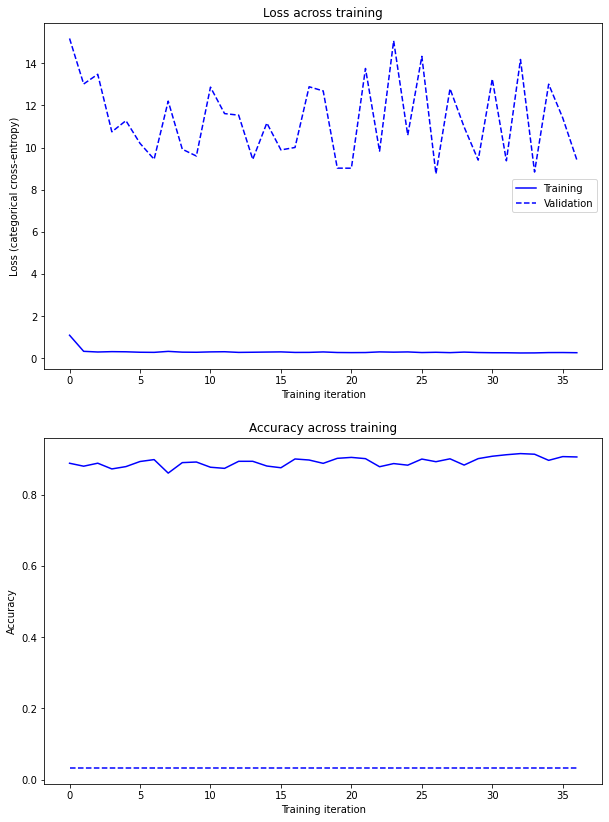

In [9]:
%matplotlib inline
# Plot results curves.
fig = plt.figure(1, figsize=(10, 14))
fig.clf()
x = range(len(history.history['loss']))
# Loss.
y_tr = history.history['loss']
y_vl = history.history['val_loss']
ax = fig.add_subplot(2, 1, 1)
ax.plot(x, y_tr, "b", label="Training")
ax.plot(x, y_vl, "b--", label="Validation")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (categorical cross-entropy)")
ax.legend()
# Accuracy.
y_tr = history.history['accuracy']
y_vl = history.history['val_accuracy']
ax = fig.add_subplot(2, 1, 2)
ax.plot(x, y_tr, "b", label="Training")
ax.plot(x, y_vl, "b--", label="Test")
ax.set_title("Accuracy across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Accuracy")
fig.show()

In [23]:
save_model_name = 'best_model_CNN_1/best'
loaded_model = tf.keras.models.load_model(save_model_name)

data_te = "sample/test.tfrecord"
dataset_te, te_total  = get_dataset(data_te, repeat=False, 
                                    batch_size=1, 
                                    dim_image=dim_image+[True], 
                                    shuffle=0)

results = loaded_model.evaluate(dataset_te)
print("Testing Loss = {0:f}, Testing Accuracy = {1:f}".format(results[0], results[1]))

labels = [x[1][0].tolist() for x in dataset_te.as_numpy_iterator()]

dataset_te, te_total  = get_dataset(data_te, repeat=False, 
                                    batch_size=1, 
                                    dim_image=dim_image+[False], 
                                    shuffle=0)

predictions = loaded_model.predict(dataset_te).tolist()

data = {'test_scores': predictions, 'test_labels': labels}

The data set contains images
127283/127283 [==============================] - 528s 4ms/step - loss: 5.9698 - accuracy: 0.0781
Testing Loss = 5.965465, Testing Accuracy = 0.078659
The data set contains images


In [22]:
#predictions = loaded_model.predict(dataset_te)
#print ([x for x in dataset_te][0])
#labels = np.concatenate([y for x, y in dataset_te], axis=0)
n_class = labels.shape[1]
 
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 
plt.figure(figsize=(8,6))
signal=[r'$W^+$',r'$W^-$',r'$Z$']
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], label='{0} (auc = {1:0.2f})'.format(signal[i], roc_auc[i]))
            
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right', fontsize=15)
plt.show()

tf.Tensor(
[[[[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  ...

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]]], shape=(1, 75, 75, 2), dtype=float32)


ValueError: not enough values to unpack (expected 2, got 1)

In [24]:
labels = data['test_labels']
scores = data['test_scores']

labels_EW_LL, scores_EW_LL = [], []
labels_EW_nonLL, scores_EW_nonLL  = [], []
labels_QCD, scores_QCD  = [], []

for idx in tqdm(range(len(labels))):
    if labels[idx][0] > 0.5 or labels[idx][1] > 0.5:
        labels_EW_LL.append([labels[idx][0], labels[idx][1]])
        total_EW_LL = scores[idx][0] + scores[idx][1]
        if int(scores[idx][2]) == 1:
            scores_EW_LL.append([0.5, 0.5])
        else:
            scores_EW_LL.append([scores[idx][0]/total_EW_LL, scores[idx][1]/total_EW_LL])
    if labels[idx][0] > 0.5 or labels[idx][2] > 0.5:
        labels_EW_nonLL.append([labels[idx][0], labels[idx][2]])
        total_EW_nonLL = scores[idx][0] + scores[idx][2]
        if int(scores[idx][1]) == 1:
            scores_EW_nonLL.append([0.5, 0.5])
        else:
            scores_EW_nonLL.append([scores[idx][0]/total_EW_nonLL, scores[idx][2]/total_EW_nonLL])
    if labels[idx][1] > 0.5 or labels[idx][2] > 0.5:
        labels_QCD.append([labels[idx][1], labels[idx][2]])
        total_QCD = scores[idx][1] + scores[idx][2]
        if int(scores[idx][0]) == 1:
            scores_QCD.append([0.5, 0.5])
        else:
            scores_QCD.append([scores[idx][1]/total_QCD, scores[idx][2]/total_QCD])

labels_EW_LL, scores_EW_LL = np.array(labels_EW_LL), np.array(scores_EW_LL)
labels_EW_nonLL, scores_EW_nonLL = np.array(labels_EW_nonLL), np.array(scores_EW_nonLL)
labels_QCD, scores_QCD = np.array(labels_QCD), np.array(scores_QCD)
        
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr['EW_LL'], tpr['EW_LL'], _ = roc_curve(labels_EW_LL[:, i], scores_EW_LL[:, i])
    roc_auc['EW_LL'] = auc(fpr['EW_LL'], tpr['EW_LL'])
    
    fpr['EW_nonLL'], tpr['EW_nonLL'], _ = roc_curve(labels_EW_nonLL[:, i], scores_EW_nonLL[:, i])
    roc_auc['EW_nonLL'] = auc(fpr['EW_nonLL'], tpr['EW_nonLL'])
    
    fpr['QCD'], tpr['QCD'], _ = roc_curve(labels_QCD[:, i], scores_QCD[:, i])
    roc_auc['QCD'] = auc(fpr['QCD'], tpr['QCD'])

plt.figure(1, figsize=(8, 6))
lw = 2
plt.plot(
    fpr['EW_LL'],
    tpr['EW_LL'],
    color="red",
    lw=lw,
    label=r"ROC curve (area = %0.2f), EW, LL" % roc_auc['EW_LL'],
)
plt.plot(
    fpr['EW_nonLL'],
    tpr['EW_nonLL'],
    color="green",
    lw=lw,
    label=r"ROC curve (area = %0.2f), EW, non-LL" % roc_auc['EW_nonLL'],
)
plt.plot(
    fpr['QCD'],
    tpr['QCD'],
    color="blue",
    lw=lw,
    label=r"ROC curve (area = %0.2f), QCD" % roc_auc['QCD'],
)
plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Testing ROC Curve")
plt.legend(loc="lower right")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127283/127283 [00:00<00:00, 195473.52it/s]
/home/samhuang/.conda/envs/sam/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1007: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/samhuang/.conda/envs/sam/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/samhuang/.conda/envs/sam/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1007: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/samhuang/.conda/envs/sam/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


IndexError: too many indices for array